<h1> Stéganographie par Methode de Parité </h1>
<i>par Claudia Delgado et Mehdi Miah - Mars 2017</i>

# Plan 

1. [Import](#import)
2. [Choices](#choices)
    1. [Choices of images](#choices_images)
    2. [Choices of secret message](#choices_message)
3. [Functions to code and decode](#functions)
4. [Application](#application)

# Import <a name="import"></a>

In [1]:
from scipy import misc
import numpy as np
from PIL import Image
import time
import matplotlib.pyplot as plt

%matplotlib inline

# Choices <a name="choices"></a>

## Choices of images <a name="choices_images"></a>

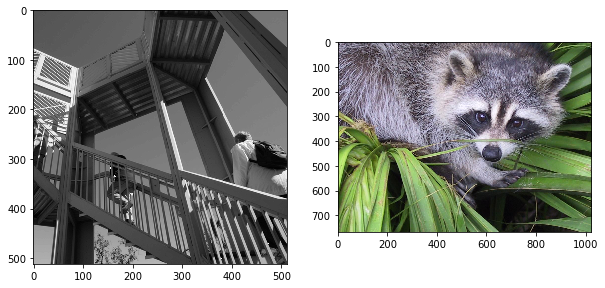

In [2]:
# Load some carrier images
carrier = misc.ascent()
carrier2 = misc.face()

image = carrier.copy() #load one of the carrier

#Plot the carriers
plt.figure(figsize = (10,10))
plt.subplot(1, 2, 1)
plt.imshow(carrier, cmap=plt.cm.gray)
plt.subplot(1, 2, 2)
plt.imshow(carrier2)

## Choice of secret message  <a name="choices_message"></a>

In [3]:
message = "Chers compatriotes, je me tiens aujourd'hui devant vous avec un sentiment d'humilité, devant la tâche qui \
nous attend, de reconnaissance pour la confiance que vous m'avez manifestée, gardant à l'esprit les sacrifices consentis \
par nos ancêtres. Je remercie le président Bush pour les services qu'il a rendus à notre nation, ainsi que pour la  \
générosité et la coopération dont il a fait preuve tout au long de cette transition. Quarante-quatre Américains ont, \
avant moi, prêté serment pour la présidence. Leurs paroles ont été prononcées pendant des vagues de prospérité et alors \
que nous vivions dans les eaux calmes de la paix. Cependant, en d'autres temps, ce serment a été prêté alors que les nuages \
s'amoncelaient et que les tempêtes faisaient rage. Dans ces moments-là, l'Amérique a poursuivi son chemin. Pas seulement en \
raison de la compétence ou de la vision de ceux qui étaient au gouvernement, mais parce que nous, le peuple, nous sommes \
restés fidèles aux idéaux de nos pairs et respectueux de nos actes fondateurs."

In [4]:
def load_message(message):
    #check that the secret message is a string
    assert type(message)==str, "Le message secret doit être un message texte"
    bin_message=''
    for i in message:
        bin_message+=(format(ord(i),'08b')) #binary code for each character
    return(bin_message)

In [5]:
short_message="Hi!"
bin_message = load_message(short_message)

# Shapes of the image and the secret message
print('The carrier image can suporter', (image.shape[0]-1)*image.shape[1], 'bits.')
print('The hidden secret in binary representation is composed of ', len(bin_message),'bits.')

The carrier image can suporter 261632 bits.
The hidden secret in binary representation is composed of  24 bits.


In [6]:
# Test if the secret message can be hidden in the carrier image
if (image.shape[0]-1)*image.shape[1] >= len(bin_message):
    print('OK, the image can carry the secret message.')
else:
    print('BEWARE, you have to trunc the secret message.')
    
# Maximum size    
x = image.shape[0]
y = image.shape[1]
capacity = ((x-1)*y)/8 # First line is only used to code the number of characters

print('The bigger dimension size is %.f x %.f which mean that your are allowed to use %.f characters.' %(x, y, capacity))

OK, the image can carry the secret message.
The bigger dimension size is 512 x 512 which mean that your are allowed to use 32704 characters.


# Functions to code and decode <a name="functions"></a>

In [7]:
def code_steganography_parity(carrier, hidden):
    '''
    Input : carrier - number between 0 and 255 corresponding to the bit code of the carrier image
          : hidden - number between 0 and 1 corresponding to 1/8 of a character
    Output : output - image resulting from the code      
    '''
    #check that the hidden number is an integer between 0 and 1 included
    assert hidden in range(0,2), "hidden should be equals to 0 or 1"

    if(carrier==255):
        carrier-=1
    if(carrier%2!=hidden%2):
        carrier+=1
    return carrier

In [8]:
def decode_steganography_parity_length_mess(output):
    '''
    Input : output - number between 0 and 255 corresponding to the bit code of the output image
    '''
    #Decode the length oh the message
    output_str = str(output)
    hidden = output_str[len(output_str)-1:]
    return(hidden)

In [9]:
def decode_steganography_parity(output):
    '''
    Input : output - number between 0 and 255 corresponding to the bit code of the output image
    '''
    #Decode the binary code
    hidden = str(output%2)

    return(hidden)

In [10]:
def code_text_in_image_parity(image, message):
    bin_message= load_message(message)
    length_message = len(bin_message)
    length_max_message = (image.shape[0]-1)*image.shape[1]
    
    assert length_max_message >= length_message , ('BEWARE, in this image you are allowed to use  %.f characters, \
    you have to trunc the secret message.' %(length_max_message/8))
    
    output = image.copy()
    size_message_bin=format(len(str(length_message)) ,'08b')   # EXPLICATION
    
    # Code for the first line of the image  : hide the length of the secret message
    for j in range(0,8):
        output[0,j]=code_steganography_parity(output[0,j], int(size_message_bin[j]))
    for i in range(1,len(str(length_message))+1):  
        output[0,i+8] = int(str(output[0,i+8])[:len(str(output[0,i+8]))-1]+str(length_message)[i-1])   
    
    # Code from the second line of the image to the end : hide the secret message
    k=0
    for i in range(1,image.shape[0]+1):
        for j in range(image.shape[1]):
            if(k<length_message):
                output[i,j] = code_steganography_parity(image[i,j], int(bin_message[k]))
            else:
                break
            k=k+1

    return(output)

In [11]:
def decode_text_into_image_parity(image):
    output = image.copy()
    size_message_bin=''
    
    # Code for the first line of the image  : get the length of the secret message
    for j in range(0,8):
        size_message_bin += decode_steganography_parity(output[0,j])
    length_message = int(size_message_bin, 2)
    nb_characters_message = ''
    for i in range(1,length_message+1):  
        nb_characters_message += decode_steganography_parity_length_mess(output[0,i+8])
    nb_characters_message = int(nb_characters_message)
    
    # Code from the second line of the image to the end : get the secret message
    hidden_bin_message = ''
    k = 0
    for i in range(1,image.shape[0]+1):
        for j in range(image.shape[1]):
            if(k<nb_characters_message):
                 hidden_bin_message += decode_steganography_parity(output[i,j])
            else:
                break
            k=k+1
    hidden_message = ''
    for l in range(int(nb_characters_message/8)):
          hidden_message +=  chr(int(hidden_bin_message[l*8:(l+1)*8],2)) 
        
    return(hidden_message)

# Application <a name="application"></a>

In [12]:
image

array([[ 83,  83,  83, ..., 117, 117, 117],
       [ 82,  82,  83, ..., 117, 117, 117],
       [ 80,  81,  83, ..., 117, 117, 117],
       ..., 
       [178, 178, 178, ...,  57,  59,  57],
       [178, 178, 178, ...,  56,  57,  57],
       [178, 178, 178, ...,  57,  57,  58]])

In [13]:
message

"Chers compatriotes, je me tiens aujourd'hui devant vous avec un sentiment d'humilité, devant la tâche qui nous attend, de reconnaissance pour la confiance que vous m'avez manifestée, gardant à l'esprit les sacrifices consentis par nos ancêtres. Je remercie le président Bush pour les services qu'il a rendus à notre nation, ainsi que pour la  générosité et la coopération dont il a fait preuve tout au long de cette transition. Quarante-quatre Américains ont, avant moi, prêté serment pour la présidence. Leurs paroles ont été prononcées pendant des vagues de prospérité et alors que nous vivions dans les eaux calmes de la paix. Cependant, en d'autres temps, ce serment a été prêté alors que les nuages s'amoncelaient et que les tempêtes faisaient rage. Dans ces moments-là, l'Amérique a poursuivi son chemin. Pas seulement en raison de la compétence ou de la vision de ceux qui étaient au gouvernement, mais parce que nous, le peuple, nous sommes restés fidèles aux idéaux de nos pairs et respectu

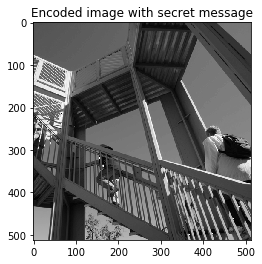

Wall time: 333 ms


In [14]:
%%time
#Encode
output=code_text_in_image_parity(image, message)

#Plot the carrier with the secret message
plt.imshow(output, cmap=plt.cm.gray)
plt.title('Encoded image with secret message' )
plt.show()

In [15]:
%%time
#Decode
decode_text_into_image_parity(output)

Wall time: 48 ms


"Chers compatriotes, je me tiens aujourd'hui devant vous avec un sentiment d'humilité, devant la tâche qui nous attend, de reconnaissance pour la confiance que vous m'avez manifestée, gardant à l'esprit les sacrifices consentis par nos ancêtres. Je remercie le président Bush pour les services qu'il a rendus à notre nation, ainsi que pour la  générosité et la coopération dont il a fait preuve tout au long de cette transition. Quarante-quatre Américains ont, avant moi, prêté serment pour la présidence. Leurs paroles ont été prononcées pendant des vagues de prospérité et alors que nous vivions dans les eaux calmes de la paix. Cependant, en d'autres temps, ce serment a été prêté alors que les nuages s'amoncelaient et que les tempêtes faisaient rage. Dans ces moments-là, l'Amérique a poursuivi son chemin. Pas seulement en raison de la compétence ou de la vision de ceux qui étaient au gouvernement, mais parce que nous, le peuple, nous sommes restés fidèles aux idéaux de nos pairs et respectu

In [16]:
output

array([[ 84,  84,  84, ..., 117, 117, 117],
       [ 82,  83,  84, ..., 118, 118, 118],
       [ 80,  81,  83, ..., 117, 117, 118],
       ..., 
       [178, 178, 178, ...,  57,  59,  57],
       [178, 178, 178, ...,  56,  57,  57],
       [178, 178, 178, ...,  57,  57,  58]])